# 3.5: 量子线路实现监督性学习

## Applying a Gate on States in a Batch

In [1]:
from tensor_network.utils import (
    iterable_have_common,
    inverse_permutation,
    check_quantum_gate,
    check_state_tensor,
    unify_tensor_dtypes,
)
import torch
from typing import List
from einops import einsum
from tensor_network.tensor_gates.functional import apply_gate

In [2]:
# |export tensor_gates.functional
def apply_gate_batched(
    *,
    quantum_states: torch.Tensor,
    gate: torch.Tensor,
    target_qubit: int | List[int],
    control_qubit: int | List[int] | None = None,
) -> torch.Tensor:
    """
    Apply a quantum gate to a quantum state tensor. It can also be used to implement controlled gates by specifying control qubits.

    Args:
        quantum_states (torch.Tensor): The batched quantum state tensor with batch dimension at 0
        gate (torch.Tensor): The quantum gate tensor, not batched.
        target_qubit (int | List[int]): The target qubit(s) to apply the gate to.
        control_qubit (int | List[int] | None): The control qubit(s) for the gate. If None, no control qubits are used.
    Returns:
        torch.Tensor: The new quantum state tensor after applying the gate.
    """
    check_state_tensor(quantum_states[0])

    # check types
    assert isinstance(target_qubit, (int, list)), "target qubit must be int or list"
    assert control_qubit is None or isinstance(control_qubit, (int, list)), (
        "control_qubit must be int or list"
    )

    # unify types
    if isinstance(target_qubit, int):
        target_qubit = [target_qubit]
    if control_qubit is None:
        control_qubit = []
    elif isinstance(control_qubit, int):
        control_qubit = [control_qubit]
    assert not iterable_have_common(target_qubit, control_qubit), (
        "target qubit and control qubit must not overlap"
    )

    batch_num = quantum_states.shape[0]
    num_qubits = quantum_states.ndim - 1  # because of batch dimension
    num_target_qubit = len(target_qubit)
    check_quantum_gate(gate, num_target_qubit)

    quantum_states, gate = unify_tensor_dtypes(quantum_states, gate)
    # permute the batch dim to the last dim
    quantum_states = torch.movedim(quantum_states, 0, -1)  # (*qubit_shapes, batch_dim)
    batch_dim_idx = quantum_states.ndim - 1

    # check indices
    for qidx in target_qubit:
        assert 0 <= qidx < num_qubits, f"target qubit index {qidx} out of range"
    for qidx in control_qubit:
        assert 0 <= qidx < num_qubits, f"control qubit index {qidx} out of range"

    if gate.ndim == 2:
        # if in matrix form, reshape to tensor form
        new_shape = [2] * (num_target_qubit * 2)
        gate = gate.reshape(new_shape)

    other_qubits = list(range(num_qubits))
    for qubit_idx in target_qubit:
        other_qubits.remove(qubit_idx)
    for qubit_idx in control_qubit:
        other_qubits.remove(qubit_idx)

    num_other_qubits = len(other_qubits)
    permute_qubit_dims = target_qubit + other_qubits + control_qubit + [batch_dim_idx]
    state = torch.permute(quantum_states, permute_qubit_dims)
    state_shape = (
        state.shape
    )  # (*target_qubit_shapes, *other_qubit_shapes, *control_qubit_shapes, batch_dim)
    # Flatten the state tensor, so that the shape is (target_qubit_shapes, other_qubit_shapes, -1, batch_dim)
    new_shape = [2] * (num_target_qubit + num_other_qubits) + [-1, batch_num]
    state = state.reshape(new_shape)
    # only when control qubits are 11111... the gate is applied
    unaffected_state = state[
        ..., :-1, :
    ]  # (*target_qubit_shapes, *other_qubit_shapes, flattened_dim-1, batch_dim)
    state_to_apply_gate = state[
        ..., -1, :
    ]  # (*target_qubit_shapes, *other_qubit_shapes, batch_dim)
    # apply gate
    batch_dim_name = "batch"
    target_qubit_names = [f"t{i}" for i in target_qubit]
    other_qubit_names = [f"o{i}" for i in other_qubits]
    gate_output_qubit_names = [f"g{i}" for i in target_qubit]
    einsum_str = "{gate_dims}, {state_dims} -> {output_dims}".format(
        gate_dims=" ".join(gate_output_qubit_names + target_qubit_names),
        state_dims=" ".join(target_qubit_names + other_qubit_names + [batch_dim_name]),
        output_dims=" ".join(gate_output_qubit_names + other_qubit_names + [batch_dim_name]),
    )
    new_state = einsum(gate, state_to_apply_gate, einsum_str)
    new_state = new_state.unsqueeze(-2)  # (*target_qubit_shapes, *other_qubit_shapes, 1, batch_dim)

    final_state = torch.cat(
        [unaffected_state, new_state], dim=-2
    )  # (*target_qubit_shapes, *other_qubit_shapes, flattened_dim)
    final_state = final_state.reshape(
        state_shape
    )  # (*target_qubit_shapes, *other_qubit_shapes, *control_qubit_shapes, batch_dim)

    # inverse the previous permutations
    inverse_permute_qubit_dims = inverse_permutation(permute_qubit_dims)
    final_state = final_state.permute(inverse_permute_qubit_dims)  # (*qubit_shapes, batch_dim)
    final_state = torch.movedim(final_state, -1, 0)  # (batch_dim, *qubit_shapes)
    return final_state


def apply_gate_nonbatched(
    *,
    quantum_state: torch.Tensor,
    gate: torch.Tensor,
    target_qubit: int | List[int],
    control_qubit: int | List[int] | None = None,
) -> torch.Tensor:
    """
    Apply a quantum gate to a quantum state tensor. It can also be used to implement controlled gates by specifying control qubits.

    Same as `apply_gate`, but use `apply_gate_batched` under the hood.

    Args:
        quantum_state (torch.Tensor): The quantum state tensor.
        gate (torch.Tensor): The quantum gate tensor, not batched.
        target_qubit (int | List[int]): The target qubit(s) to apply the gate to.
        control_qubit (int | List[int] | None): The control qubit(s) for the gate. If None, no control qubits are used.
    Returns:
        torch.Tensor: The new quantum state tensor after applying the gate.
    """
    quantum_state = quantum_state.unsqueeze(0)  # add batch dimension
    return apply_gate_batched(
        quantum_states=quantum_state,
        gate=gate,
        target_qubit=target_qubit,
        control_qubit=control_qubit,
    ).squeeze(0)


# need this to wrap apply_gate because of vmap's specification on kwargs
def __apply_gate_for_vmap(
    state: torch.Tensor,
    gate: torch.Tensor,
    *,
    target_qubit: int | List[int],
    control_qubit: int | List[int] | None = None,
):
    return apply_gate(
        quantum_state=state, gate=gate, target_qubit=target_qubit, control_qubit=control_qubit
    )


apply_gate_batched_with_vmap = torch.vmap(__apply_gate_for_vmap, in_dims=(0, None))

### Test

In [3]:
# set up importing for ref code
from tensor_network import setup_ref_code_import
from Library.QuantumState import TensorPureState
from copy import deepcopy

From setup_ref_code_import:
  Added reference_code_path='/Users/zhiqiu/offline_code/personal/tensor_network/reference_code' to sys.path.
  You can import the reference code now.


In [4]:
# initialize a quantum state of 4 qubits
state = TensorPureState(nq=4, dtype=torch.complex128)

# initialize a random quantum gate of 1 qubit
gate1 = torch.randn(2, 2, dtype=torch.complex128)
# initialize a random quantum gate of 2 qubits
gate2_mat = torch.randn(4, 4, dtype=torch.complex128)
gate2_tensor = gate2_mat.reshape(2, 2, 2, 2)
# initialize a random quantum gate of 3 qubits
gate3_mat = torch.randn(8, 8, dtype=torch.complex128)
gate3_tensor = gate3_mat.reshape(2, 2, 2, 2, 2, 2)
# initialize a random quantum gate of 4 qubits
gate4_mat = torch.randn(16, 16, dtype=torch.complex128)
gate4_tensor = gate4_mat.reshape(2, 2, 2, 2, 2, 2, 2, 2)

# tests
for i, (gate_mat, gate_tensor) in enumerate(
    [
        (gate1, gate1),
        (gate2_mat, gate2_tensor),
        (gate3_mat, gate3_tensor),
        (gate4_mat, gate4_tensor),
    ]
):
    qubit_num = i + 1
    s = deepcopy(state)
    t = s.tensor.clone()
    target_qubit = list(range(qubit_num))
    s.act_single_gate(gate=gate_tensor, pos=target_qubit)
    result_ref = s.tensor
    result_mat = apply_gate(quantum_state=t, gate=gate_mat, target_qubit=target_qubit)
    result_tensor = apply_gate(quantum_state=t, gate=gate_tensor, target_qubit=target_qubit)

    result_batched_mat = apply_gate_batched(
        quantum_states=t.unsqueeze(0),
        gate=gate_mat,
        target_qubit=target_qubit,
    ).squeeze(0)
    result_batched_tensor = apply_gate_batched(
        quantum_states=t.unsqueeze(0),
        gate=gate_tensor,
        target_qubit=target_qubit,
    ).squeeze(0)
    result_batched_mat_vmap = apply_gate_batched_with_vmap(
        t.unsqueeze(0),
        gate_mat,
        target_qubit=target_qubit,
    ).squeeze(0)
    result_batched_tensor_vmap = apply_gate_batched_with_vmap(
        t.unsqueeze(0),
        gate_tensor,
        target_qubit=target_qubit,
    ).squeeze(0)

    assert torch.allclose(result_batched_mat, result_ref), (
        f"result: {result_batched_mat}, result_ref: {result_ref}"
    )
    assert torch.allclose(result_mat, result_ref), f"result: {result_mat}, result_ref: {result_ref}"
    assert torch.allclose(result_batched_mat_vmap, result_ref), (
        f"result: {result_batched_mat_vmap}, result_ref: {result_ref}"
    )

    assert torch.allclose(result_tensor, result_ref), (
        f"result: {result_tensor}, result_ref: {result_ref}"
    )
    assert torch.allclose(result_batched_tensor, result_ref), (
        f"result: {result_batched_tensor}, result_ref: {result_ref}"
    )
    assert torch.allclose(result_batched_tensor_vmap, result_ref), (
        f"result: {result_batched_tensor_vmap}, result_ref: {result_ref}"
    )

### Comparison: batch operation vs vmap

In [5]:
from time import time
from matplotlib import pyplot as plt

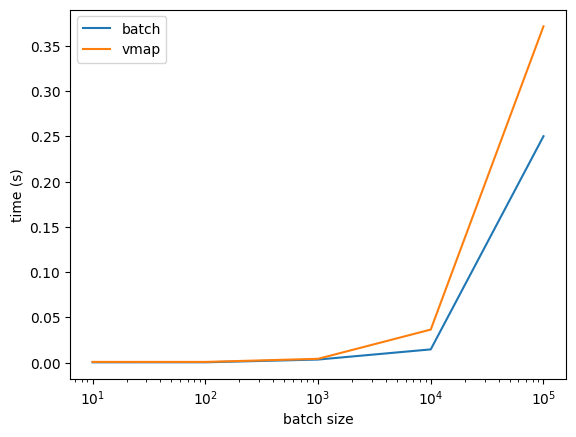

In [6]:
num_qubits = 6
batch_sizes = [10, 100, 1000, 10000, 100000]
batch = 1000

# initialize a random quantum gate of 1 qubit
gate1 = torch.randn(2, 2, dtype=torch.complex128)
# initialize a random quantum gate of 2 qubits
gate2_mat = torch.randn(4, 4, dtype=torch.complex128)
gate2_tensor = gate2_mat.reshape(2, 2, 2, 2)
# initialize a random quantum gate of 3 qubits
gate3_mat = torch.randn(8, 8, dtype=torch.complex128)
gate3_tensor = gate3_mat.reshape(2, 2, 2, 2, 2, 2)
# initialize a random quantum gate of 4 qubits
gate4_mat = torch.randn(16, 16, dtype=torch.complex128)
gate4_tensor = gate4_mat.reshape(2, 2, 2, 2, 2, 2, 2, 2)

gates = [
    gate1,
    gate2_tensor,
    gate3_tensor,
    gate4_tensor,
]

batch_times = []
vmap_times = []

for batch in batch_sizes:
    states = torch.randn(*([batch] + [2] * num_qubits), dtype=torch.complex64)

    start = time()

    for i, gate in enumerate(gates):
        qubit_num = i + 1
        target_qubit = list(range(qubit_num))
        apply_gate_batched(
            quantum_states=states,
            gate=gate,
            target_qubit=target_qubit,
        )

    end = time()
    batch_times.append(end - start)

    start = time()
    for i, gate in enumerate(gates):
        qubit_num = i + 1
        target_qubit = list(range(qubit_num))
        apply_gate_batched_with_vmap(
            states,
            gate,
            target_qubit=target_qubit,
        )
    end = time()
    vmap_times.append(end - start)


plt.plot(batch_sizes, batch_times, label="batch")
plt.plot(batch_sizes, vmap_times, label="vmap")
plt.xlabel("batch size")
plt.ylabel("time (s)")
plt.legend()
plt.xscale("log")

## Iris Classification
TODO